In [189]:
import pandas as pd
from hdfs import InsecureClient
from matplotlib import pyplot as plt
import numpy as np
import os
from functools import reduce
from scipy import misc
import datetime as dt
import matplotlib.dates as md
headers = ["timestamp", "value"]
plt.rcParams.update({'font.size': 14})

In [190]:
def readThroughput(file, k):
    # read file
    table = pd.read_csv(file, header=None, sep=",", names=['realTS', 'eventTS', 'nodeID', 'events'])

    # store events per nodeID
    dfs = []
    for i in range(k):
        dfs.append(table[(table['nodeID'] == i)][['realTS', 'events']])

    return dfs

In [191]:
def readWorkerMetrics(file, k):
    # read file
    table = pd.read_csv(file, header=None, sep=",", names=['realTS', 'eventTS', 'nodeID', 'eventType'])

    # store events per nodeID
    dfs = []
    for i in range(k):
        dfs.append(table[(table['nodeID'] == i)][['realTS', 'eventType']])

    return dfs

In [192]:
def readMetrics(file):
    df = pd.read_csv(file, header=None, sep=",", names=["realTS", "eventTS", "metricType"])

    firstTs = df['realTS'].iloc[0]
    dfRounds = df[(df['metricType'] == 'ROUND')]

    x_axis = (dfRounds['realTS'] - firstTs)/1000
    return x_axis

In [193]:
def computeDerivative(x, y, dt):

    # calculate number of 'x' in interval of 'dt' seconds
    x_int = []
    count = 0
    distinct_seconds = 1
    for time in x:
        if(time - distinct_seconds < 0):
            count += 1
        else:
            x_int.append(count)
            distinct_seconds += dt
            count = 1

    # calculate for every 'x' : end_y - start_y that correspond to that 'x' and do that for every node

    y_p = []
    start = 0
    end = 0
    for i in x_int:
        start = end
        end += i
        y_p.append((y.iloc[end] - y.iloc[start])/dt)

    
    return [x*dt for x in range(0, len(x_int))], y_p


In [194]:
def plotThroughput(e, k, rb, model, h):
    filename = '_e'+str(e)+'_k'+str(k)+'_'+rb+'_'+model
    dfs = readThroughput('throughput'+filename, k)

    x_axis_rounds = readMetrics('coordinatorMetrics'+filename)

    # define x axis starting from 0 (in seconds)
    x_axis_from_0 = []
    for i in range(k):
        firstTs = dfs[i]['realTS'].iloc[0]
        x_axis_from_0.append((dfs[i]['realTS'] - firstTs)/1000)

    # PLOT Number of events
    plt.figure(figsize=(15,5))
    ax=plt.gca()
    for i in range(k):
        plt.plot(x_axis_from_0[i], dfs[i]['events'], label=i)

    plt.title('# Events by elapsed time')
    plt.xlabel('Processing Time (sec)')
    plt.ylabel('# Events')
    plt.grid()
    plt.legend()

    # PLOT derivative of throughput
    plt.figure(figsize=(15,5))
    ax=plt.gca()
    for i in range(k):
        x_p, y_p = computeDerivative(x_axis_from_0[i], dfs[i]['events'], h)
        plt.plot(x_p, y_p, label=i)
    plt.title('Deriv. of throughput by elapsed time (interval: '+str(h)+' sec)')
    plt.xlabel('Processing Time (sec)')
    plt.ylabel('Events/Second')
    plt.grid()
    plt.legend()

    # PLOT throughput
    plt.figure(figsize=(15,5))
    ax=plt.gca()
    for i in range(k):
        plt.plot(x_axis_from_0[i], dfs[i]['events']/x_axis_from_0[i], label=i)

    for xc in x_axis_rounds:
        plt.axvline(x=xc, color='gray', alpha=0.5)
    plt.title('Events/sec by elapsed time')
    plt.xlabel('Processing Time (sec)')
    plt.ylabel('Events/Second')
    plt.legend(loc='center right')


In [195]:
def plotRounds(e, rb, model):
    k = [2,4,8,12,20]
    symbol = ['+','_','|','*','3']
    files = []
    for i in k:
        files.append('coordinatorMetrics_e'+e+'_k'+str(i)+'_'+rb+'_'+model)
    
    dfs = []
    for i in range(len(k)):
        dfs.append(pd.read_csv(files[i], header=None, sep=",", names=["realTS", "eventTS", "metricType"]))

    rounds = []
    y = []
    x_axis = []
    for i in range(len(k)):
        firstTs = dfs[i]['realTS'].iloc[0]
        rounds.append(dfs[i][(dfs[i]['metricType'] == 'ROUND')])
        y.append(rounds[i][['realTS']])
        y[i].insert(1, "Round", range(1, 1 + len(y[i])))
        x_axis.append((rounds[i]['realTS'] - firstTs)/1000)

    plt.figure(figsize=(15,10))
    ax=plt.gca()
    for i in range(len(k)):
        plt.plot(x_axis[i], y[i]['Round'], '-'+symbol[i] ,label='k = '+str(k[i]))
    plt.title('Rounds by elapsed time ('+rb+', '+model+')')
    plt.xlabel('Processing Time (sec)')
    plt.ylabel('Rounds')
    plt.grid()
    plt.legend()
    

In [196]:
def plotSubRounds(e,rb, model):
    k = [2,4,8,12,20]
    symbol = ['+','_','|','*','3']
    files = []
    for i in k:
        files.append('coordinatorMetrics_e'+e+'_k'+str(i)+'_'+rb+'_'+model)
    
    dfs = []
    for i in range(len(k)):
        dfs.append(pd.read_csv(files[i], header=None, sep=",", names=["realTS", "eventTS", "metricType"]))

    subrounds = []
    y = []
    x_axis = []
    for i in range(len(k)):
        firstTs = dfs[i]['realTS'].iloc[0]
        subrounds.append(dfs[i][(dfs[i]['metricType'] == 'SUBROUND')])
        y.append(subrounds[i][['realTS']])
        y[i].insert(1, "Subround", range(1, 1 + len(y[i])))
        x_axis.append((subrounds[i]['realTS'] - firstTs)/1000)

    plt.figure(figsize=(15,10))
    ax=plt.gca()
    for i in range(len(k)):
        plt.plot(x_axis[i], y[i]['Subround'], '-'+symbol[i] ,label='k = '+str(k[i]))
    plt.title('Subrounds by elapsed time ('+rb+', '+model+')')
    plt.xlabel('Processing Time (sec)')
    plt.ylabel('Subrounds')
    plt.grid()
    plt.legend()

In [197]:
def plotIncrementsPerRound(e, k, rb, model):

    file = 'workerMetrics_e'+str(e)+'_k'+str(k)+'_'+rb+'_'+model
    
    dfs = readWorkerMetrics(file, k)

    x = []
    y = []
    for node in range(k):
        incPerRound = []
        sentInc = 0
        rounds = 0
        for eType in dfs[node]['eventType']:
            if(eType == 'RECEIVED_ESTIMATE'):
                rounds += 1
                incPerRound.append(sentInc)
                sentInc = 0


            if(eType == 'SENT_INCREMENT'):
                sentInc += 1

        x.append(range(1, 1 + rounds))
        y.append(incPerRound)    


    plt.figure(figsize=(15,5))
    ax=plt.gca()
    for i in range(k):
        plt.plot(x[i], y[i], label=i)
    plt.title('Increments/Worker by FGM Rounds ('+rb+', '+model+')')
    plt.xlabel('FGM Rounds')
    plt.ylabel('Increments / Round')
    plt.grid()
    plt.legend()


In [198]:
def plotIncrementsPerSubRound(e, k, rb, model):

    file = 'workerMetrics_e'+str(e)+'_k'+str(k)+'_'+rb+'_'+model
    
    dfs = readWorkerMetrics(file, k)

    x = []
    y = []
    for node in range(k):
        incPerRound = []
        sentInc = 0
        rounds = 0
        for eType in dfs[node]['eventType']:
            if(eType == 'RECEIVED_QUANTUM' or eType == 'RECEIVED_ESTIMATE'):
                rounds += 1
                incPerRound.append(sentInc)
                sentInc = 0


            if(eType == 'SENT_INCREMENT'):
                sentInc += 1

        x.append(range(1, 1 + rounds))
        y.append(incPerRound)    


    plt.figure(figsize=(15,5))
    ax=plt.gca()
    for i in range(k):
        plt.plot(x[i], y[i], label=i)
    plt.title('Increments/Worker by FGM SubRounds ('+rb+', '+model+')')
    plt.xlabel('FGM SubRounds')
    plt.ylabel('Increments / SubRound')
    plt.grid()
    plt.legend()

In [199]:
def plotIncrementsPerTotal(e, k, rb, model):

    file = 'workerMetrics_e'+str(e)+'_k'+str(k)+'_'+rb+'_'+model
    
    dfs = readWorkerMetrics(file, k)

    x = []
    y = []
    plt.figure(figsize=(15,5))
    ax=plt.gca()
    for i in range(k):
        firstTs = dfs[i]['realTS'].iloc[0]
        y.append(dfs[i][(dfs[i]['eventType'] == 'SENT_INCREMENT')][['realTS']])
        y[i].insert(1, "Increments", range(1, 1 + len(y[i])))
        x.append((y[i]['realTS'] - firstTs)/1000)   
        plt.plot(x[i], y[i]['Increments'], label=i)

    plt.title('Increments/Worker by elapsed time ('+rb+', '+model+')')
    plt.xlabel('Processing Time (sec)')
    plt.ylabel('# Increments')
    plt.grid()
    plt.legend()

In [200]:
def plotTimeVsTime(e, k, rb, model):

    file = 'coordinatorMetrics_e'+str(e)+'_k'+str(k)+'_'+rb+'_'+model
    
    df = pd.read_csv(file, header=None, sep=",", names=["realTS", "eventTS", "metricType"])

    plt.figure(figsize=(15,5))
    ax=plt.gca()

    firstRealTs = df['realTS'].iloc[0]
    firstEventTs = df['eventTS'].iloc[1]    
    x = (df['realTS'][1:] - firstRealTs)/1000
    y = (df['eventTS'][1:] - firstEventTs)/1000/60/60
    plt.plot(x, y)

    plt.title('Event time by Processing time ('+rb+', '+model+')')
    plt.xlabel('Processing Time (sec)')
    plt.ylabel('Event Time (hours)')
    plt.grid()
    plt.legend()

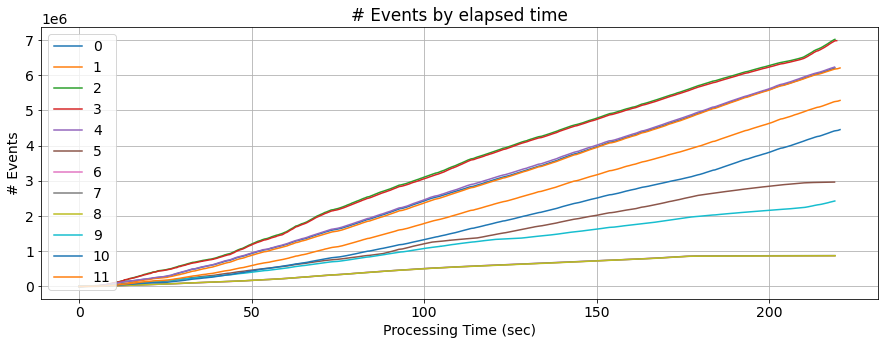

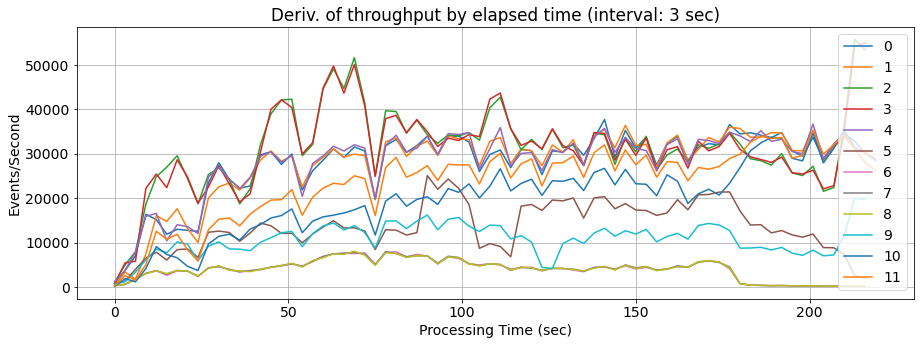

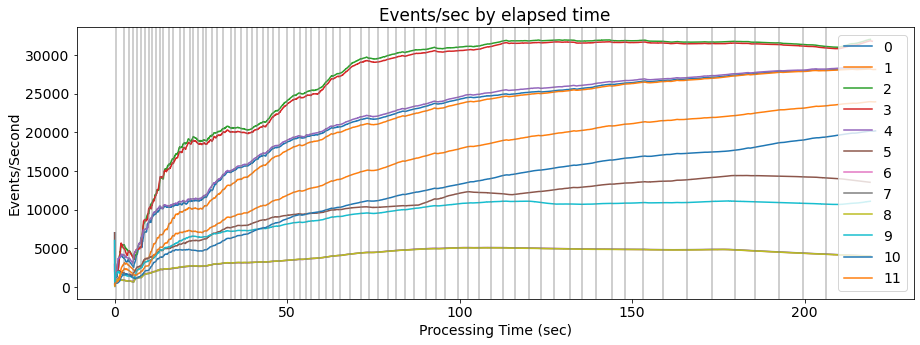

In [206]:
plotThroughput(e = 10, k = 12, rb = 'norb', model = 'cr', h = 3)

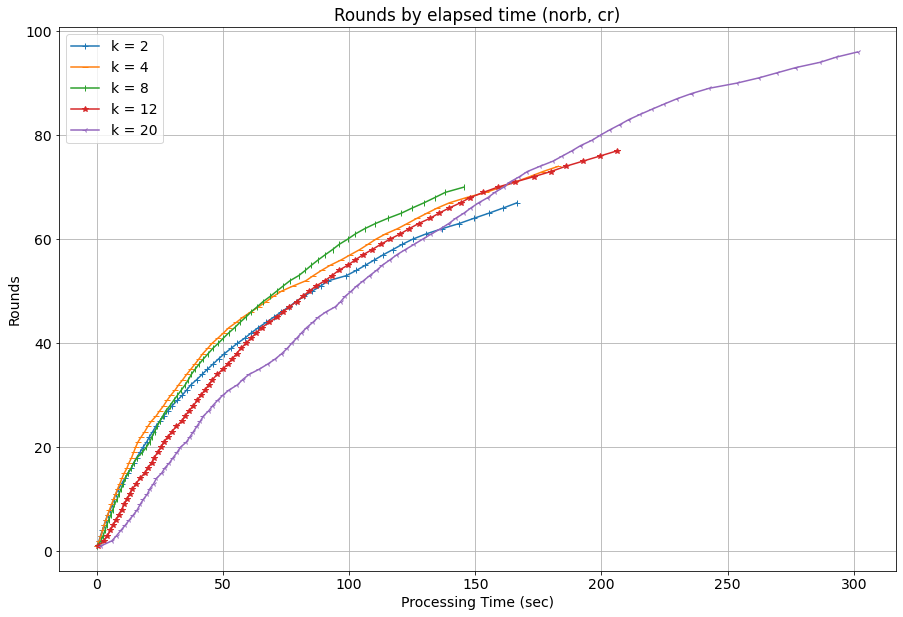

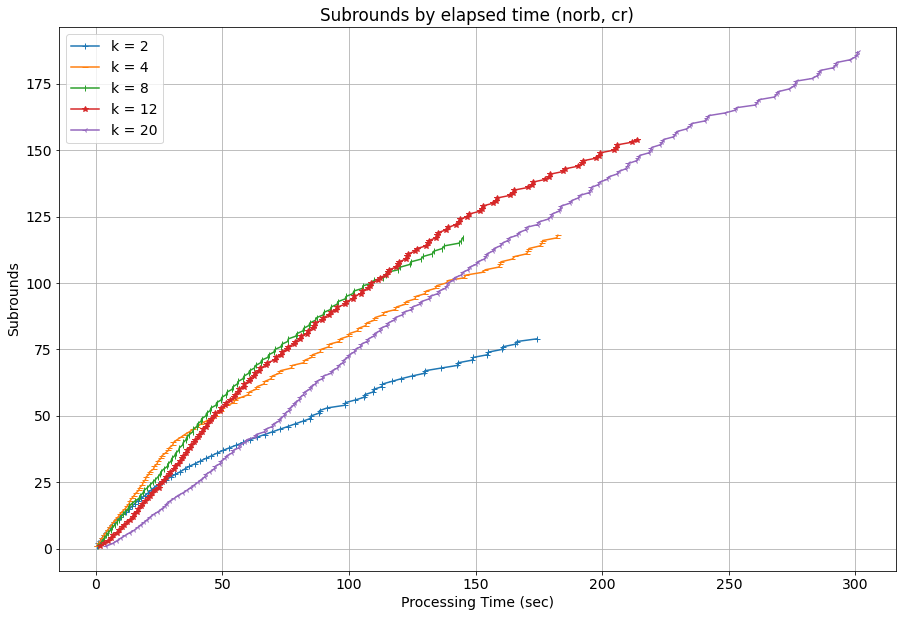

In [202]:
plotRounds(e = '10', rb = 'norb', model = 'cr')
plotSubRounds(e = '10', rb = 'norb', model = 'cr')

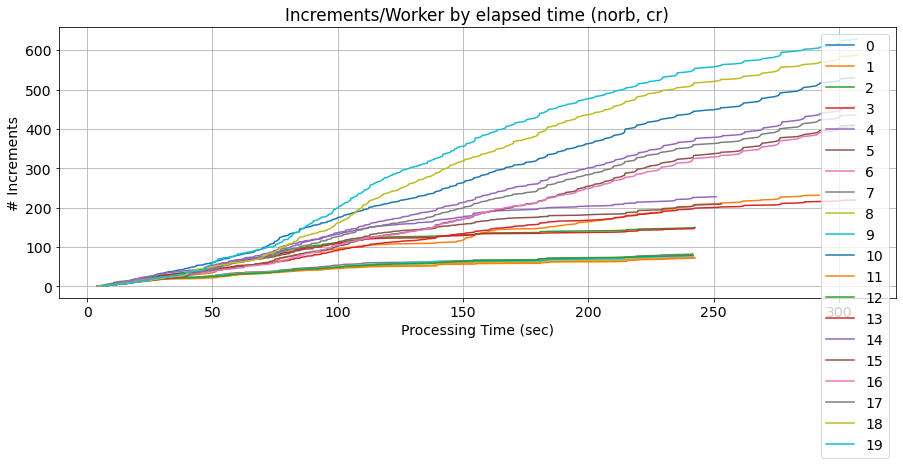

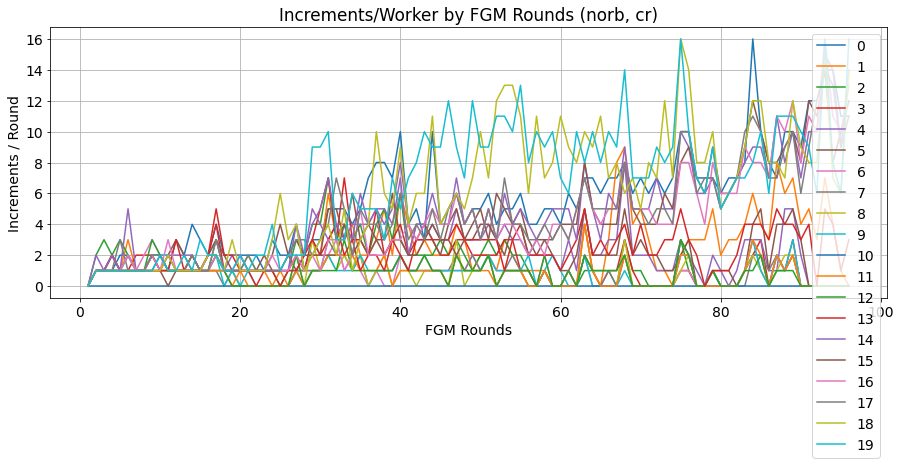

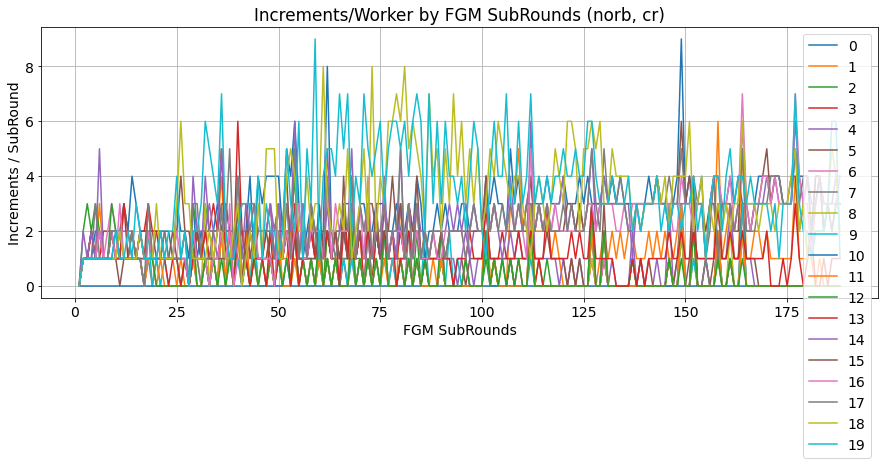

In [203]:
plotIncrementsPerTotal(e = 10, k = 20, rb = 'norb', model = 'cr')
plotIncrementsPerRound(e = 10, k = 20, rb = 'norb', model = 'cr')
plotIncrementsPerSubRound(e = 10, k = 20, rb = 'norb', model = 'cr')

No handles with labels found to put in legend.


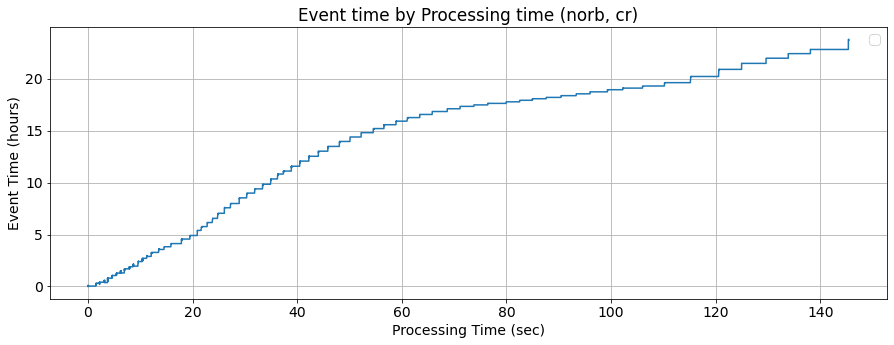

In [204]:
plotTimeVsTime(e = 10, k = 8, rb = 'norb', model = 'cr')